## 0 - Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.config import run_functions_eagerly

## 1 - Data Preparation

In [3]:
X_train = np.load("train_images.npy")
y_train = np.load("train_labels.npy")
X_test = np.load("test_images.npy")
y_test = np.load("test_labels.npy")

In [4]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [5]:
# Normalize images
X_train = X_train.astype('float32') # already normalized
X_test = X_test.astype('float32') / 255.0
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data X_test:(10000, 28, 28, 1)



In [6]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)
print(f'Shape of data X_train_cnn :{X_train_cnn .shape}\n')
print(f'Shape of data X_test_cnn :{X_test_cnn .shape}\n')

Shape of data X_train_cnn :(60000, 28, 28, 1)

Shape of data X_test_cnn :(10000, 28, 28, 1)



## 2 - Data Viz

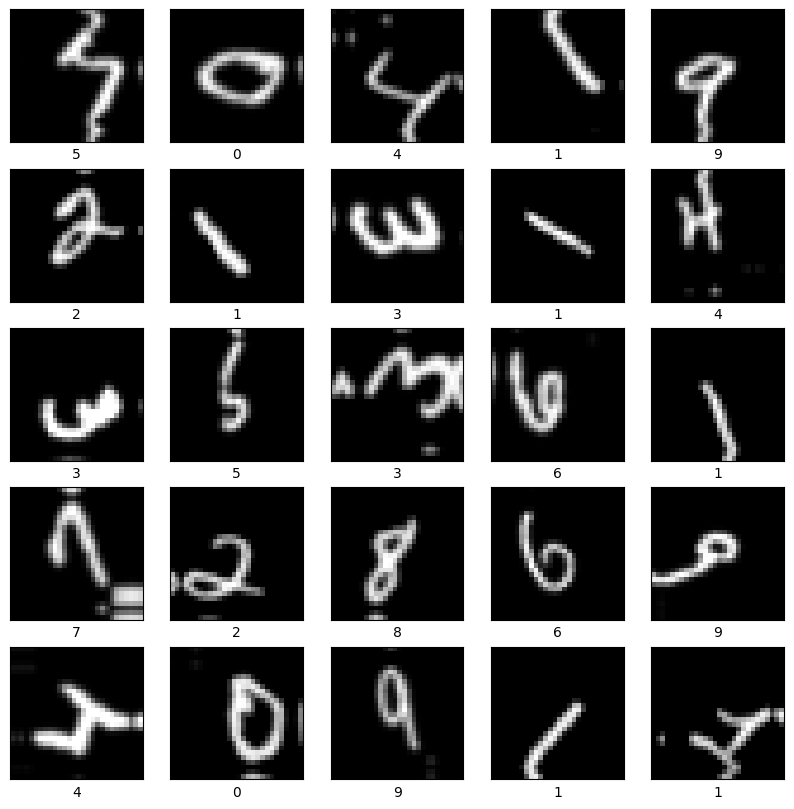

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

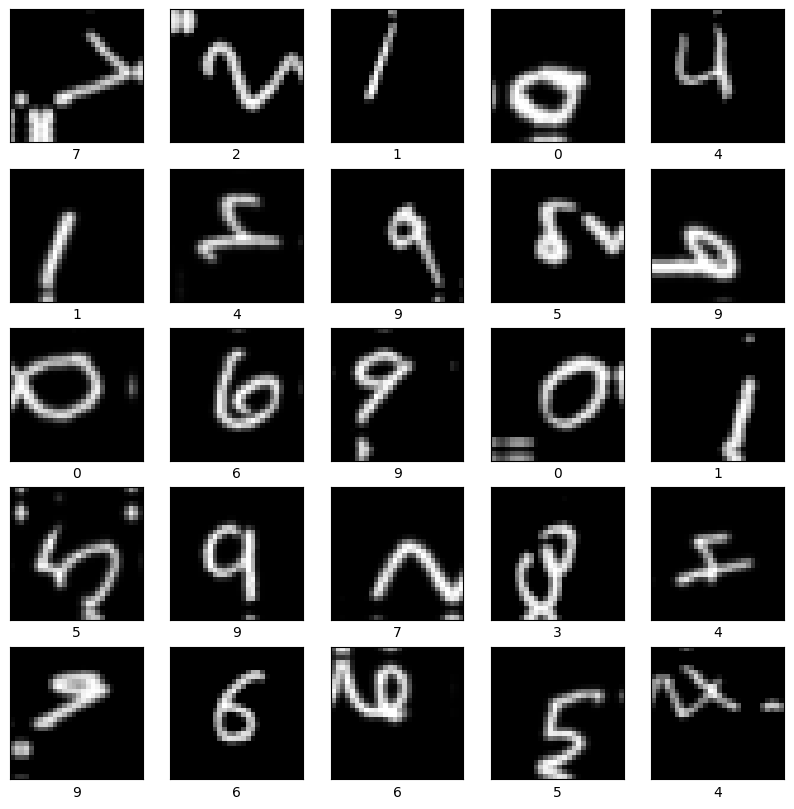

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.gray)
    plt.xlabel(y_test[i])
plt.show()

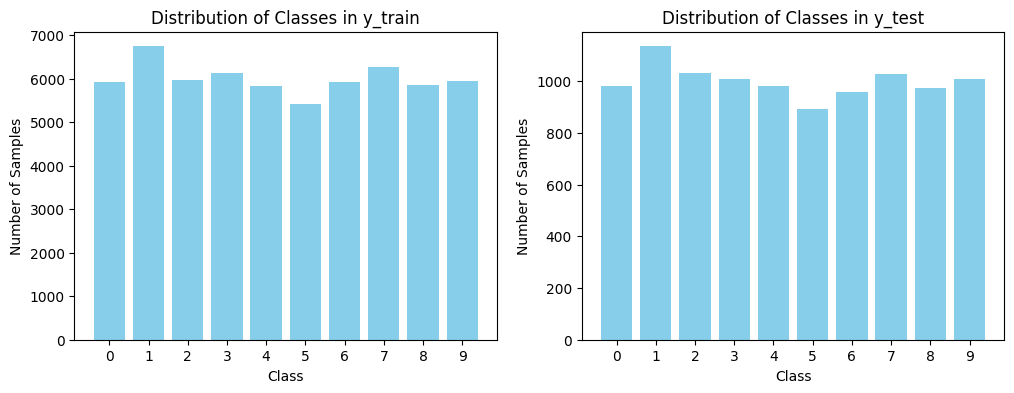

In [9]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)
plt.show()

## 3 - CNN Modele

### Parameters

In [10]:
outer_k_folds = 5
inner_k_folds = 5
epochs_cnn = 15
monitor_callback_cnn = "val_accuracy"
patience_callback_cnn = 3

### Modele

In [11]:
# Function to create CNN model
def create_cnn_model(dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=RMSprop(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [12]:
# Define the parameter grid for inner CV
param_grid = {
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.0001, 0.001],
    'batch_size': [64, 128]
}

In [ ]:
# Outer CV loop
outer_cv = StratifiedKFold(n_splits=outer_k_folds, shuffle=True)
outer_results = []
best_models = []

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X_train_cnn, y_train)):
    print(f"\n=== Outer Fold {outer_fold + 1}/{outer_k_folds} ===")

    X_outer_train, X_outer_test = X_train_cnn[outer_train_idx], X_train_cnn[outer_test_idx]
    y_outer_train, y_outer_test = y_train[outer_train_idx], y_train[outer_test_idx]

    # Inner CV loop for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=inner_k_folds, shuffle=True)
    best_inner_score = -np.inf
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"\nTesting parameters: {params}")
        inner_scores = []

        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_outer_train, y_outer_train)):
            print(f"-- Inner fold: {inner_fold+1}/{inner_k_folds}  --")
            X_inner_train, X_inner_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
            y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]

            model = create_cnn_model(dropout_rate=params['dropout_rate'], learning_rate=params['learning_rate'])

            history = model.fit(
                X_inner_train, y_inner_train,
                epochs=epochs_cnn,
                batch_size=params['batch_size'],
                validation_data=(X_inner_val, y_inner_val),
                callbacks=[EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, restore_best_weights=True)],
                verbose=1
            )

            _, val_accuracy = model.evaluate(X_inner_val, y_inner_val, verbose=0, batch_size=params['batch_size'])
            inner_scores.append(val_accuracy)

        mean_inner_score = np.mean(inner_scores)
        print(f"Mean validation accuracy for {params}: {mean_inner_score:.4f}")

        if mean_inner_score > best_inner_score:
            best_inner_score = mean_inner_score
            best_params = params
            best_model = model

    print(f"Best parameters for outer fold {outer_fold + 1}: {best_params}")
    print(f"Best inner validation accuracy: {best_inner_score:.4f}")

    # Re-train the best model on the entire outer training set with the best parameters
    best_model = create_cnn_model(dropout_rate=best_params['dropout_rate'], learning_rate=best_params['learning_rate'])
    best_model.fit(
        X_outer_train, y_outer_train,
        epochs=epochs_cnn,
        batch_size=best_params['batch_size'],  # Use the best batch_size
        callbacks=[EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, restore_best_weights=True)],
        verbose=0
    )

    # Evaluate on the outer test set
    _, outer_test_accuracy = best_model.evaluate(X_outer_test, y_outer_test, verbose=0, batch_size=best_params['batch_size'])
    print(f"Outer Fold {outer_fold + 1} - Test Accuracy: {outer_test_accuracy:.4f}")
    outer_results.append(outer_test_accuracy)
    best_models.append(best_model)


=== Outer Fold 1/5 ===

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
-- Inner fold: 1/5  --


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2208 - loss: 2.3151 - val_accuracy: 0.3775 - val_loss: 1.8508
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4317 - loss: 1.6089 - val_accuracy: 0.6689 - val_loss: 1.0458
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5736 - loss: 1.2408 - val_accuracy: 0.7555 - val_loss: 0.7760
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6756 - loss: 0.9746 - val_accuracy: 0.8128 - val_loss: 0.5883
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7379 - loss: 0.8064 - val_accuracy: 0.8496 - val_loss: 0.4826
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7838 - loss: 0.6669 - val_accuracy: 0.8746 - val_loss: 0.4124
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8105 - loss: 0.5896 - val_accuracy: 0.8847 - val_loss: 0.3664
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8320 - loss: 0.5219 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3631 - loss: 1.9300 - val_accuracy: 0.6661 - val_loss: 0.9821
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7795 - loss: 0.6963 - val_accuracy: 0.8969 - val_loss: 0.3421
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8536 - loss: 0.4777 - val_accuracy: 0.9091 - val_loss: 0.3013
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8855 - loss: 0.3808 - val_accuracy: 0.9172 - val_loss: 0.2820
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8946 - loss: 0.3550 - val_accuracy: 0.9197 - val_loss: 0.2690
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9089 - loss: 0.3131 - val_accuracy: 0.9282 - val_loss: 0.2476
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9164 - loss: 0.2940 - val_accuracy: 0.9295 - val_loss: 0.2649
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9203 - loss: 0.2771 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1566 - loss: 2.6027 - val_accuracy: 0.2977 - val_loss: 2.0207
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2902 - loss: 1.9856 - val_accuracy: 0.4922 - val_loss: 1.5351
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3885 - loss: 1.7212 - val_accuracy: 0.5900 - val_loss: 1.2462
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4761 - loss: 1.4948 - val_accuracy: 0.6681 - val_loss: 1.0264
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5499 - loss: 1.2956 - val_accuracy: 0.7354 - val_loss: 0.8349
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6135 - loss: 1.1314 - val_accuracy: 0.7892 - val_loss: 0.6834
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6734 - loss: 0.9798 - val_accuracy: 0.8106 - val_loss: 0.5911
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7067 - loss: 0.8821 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2757 - loss: 2.1663 - val_accuracy: 0.6677 - val_loss: 1.0511
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6476 - loss: 1.0594 - val_accuracy: 0.8401 - val_loss: 0.5195
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7802 - loss: 0.7020 - val_accuracy: 0.8968 - val_loss: 0.3489
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8265 - loss: 0.5726 - val_accuracy: 0.8724 - val_loss: 0.3984
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8490 - loss: 0.5056 - val_accuracy: 0.8915 - val_loss: 0.3445
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8618 - loss: 0.4570 - val_accuracy: 0.9062 - val_loss: 0.3467
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8741 - loss: 0.4202 - val_accuracy: 0.9185 - val_loss: 0.2813
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8773 - loss: 0.4089 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1915 - loss: 2.3747 - val_accuracy: 0.1124 - val_loss: 4.7043
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3587 - loss: 1.8130 - val_accuracy: 0.4734 - val_loss: 1.5853
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4675 - loss: 1.5119 - val_accuracy: 0.6696 - val_loss: 1.0508
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5613 - loss: 1.2778 - val_accuracy: 0.7485 - val_loss: 0.8244
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6414 - loss: 1.0650 - val_accuracy: 0.7894 - val_loss: 0.6843
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6939 - loss: 0.9165 - val_accuracy: 0.8234 - val_loss: 0.5715
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7350 - loss: 0.7999 - val_accuracy: 0.8511 - val_loss: 0.4861
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7703 - loss: 0.6948 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3347 - loss: 2.0917 - val_accuracy: 0.2614 - val_loss: 3.7691
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7594 - loss: 0.7397 - val_accuracy: 0.6779 - val_loss: 0.9554
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8507 - loss: 0.4671 - val_accuracy: 0.9103 - val_loss: 0.2970
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8880 - loss: 0.3596 - val_accuracy: 0.9077 - val_loss: 0.3051
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9088 - loss: 0.2925 - val_accuracy: 0.9254 - val_loss: 0.2584
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9196 - loss: 0.2553 - val_accuracy: 0.9362 - val_loss: 0.2094
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9277 - loss: 0.2309 - val_accuracy: 0.9248 - val_loss: 0.2789
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9338 - loss: 0.2124 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1511 - loss: 2.6942 - val_accuracy: 0.1124 - val_loss: 4.7113
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2634 - loss: 2.0402 - val_accuracy: 0.3359 - val_loss: 1.9360
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3435 - loss: 1.8405 - val_accuracy: 0.5340 - val_loss: 1.4565
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4138 - loss: 1.6597 - val_accuracy: 0.6226 - val_loss: 1.2269
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4721 - loss: 1.5057 - val_accuracy: 0.6594 - val_loss: 1.0770
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5350 - loss: 1.3360 - val_accuracy: 0.7146 - val_loss: 0.9363
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5791 - loss: 1.2184 - val_accuracy: 0.7592 - val_loss: 0.8004
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6237 - loss: 1.0975 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2539 - loss: 2.2769 - val_accuracy: 0.1231 - val_loss: 6.9201
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6160 - loss: 1.1373 - val_accuracy: 0.7546 - val_loss: 0.7610
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7554 - loss: 0.7589 - val_accuracy: 0.8776 - val_loss: 0.4190
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8157 - loss: 0.5821 - val_accuracy: 0.8897 - val_loss: 0.3544
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8483 - loss: 0.5024 - val_accuracy: 0.9162 - val_loss: 0.2866
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8638 - loss: 0.4333 - val_accuracy: 0.9176 - val_loss: 0.2889
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8777 - loss: 0.3947 - val_accuracy: 0.9314 - val_loss: 0.2370
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8899 - loss: 0.3647 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Outer Fold 1 - Test Accuracy: 0.9523

=== Outer Fold 2/5 ===

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
-- Inner fold: 1/5  --


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2116 - loss: 2.3079 - val_accuracy: 0.4363 - val_loss: 1.6801
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4395 - loss: 1.6081 - val_accuracy: 0.6768 - val_loss: 1.0211
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5883 - loss: 1.2049 - val_accuracy: 0.7776 - val_loss: 0.7246
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6796 - loss: 0.9592 - val_accuracy: 0.8261 - val_loss: 0.5579
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7408 - loss: 0.7878 - val_accuracy: 0.8650 - val_loss: 0.4489
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7871 - loss: 0.6567 - val_accuracy: 0.8750 - val_loss: 0.3976
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8225 - loss: 0.5643 - val_accuracy: 0.8948 - val_loss: 0.3419
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8375 - loss: 0.5056 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3575 - loss: 1.9573 - val_accuracy: 0.7508 - val_loss: 0.7546
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7755 - loss: 0.7036 - val_accuracy: 0.8775 - val_loss: 0.4031
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8553 - loss: 0.4727 - val_accuracy: 0.9211 - val_loss: 0.2838
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8836 - loss: 0.3930 - val_accuracy: 0.9254 - val_loss: 0.2575
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9013 - loss: 0.3305 - val_accuracy: 0.9235 - val_loss: 0.2729
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9123 - loss: 0.2946 - val_accuracy: 0.9321 - val_loss: 0.2364
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9238 - loss: 0.2629 - val_accuracy: 0.9335 - val_loss: 0.2406
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9259 - loss: 0.2542 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1568 - loss: 2.6026 - val_accuracy: 0.2782 - val_loss: 2.0658
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2947 - loss: 1.9652 - val_accuracy: 0.4997 - val_loss: 1.5233
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3852 - loss: 1.7227 - val_accuracy: 0.5899 - val_loss: 1.2612
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4761 - loss: 1.4911 - val_accuracy: 0.6683 - val_loss: 1.0273
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5467 - loss: 1.3023 - val_accuracy: 0.7306 - val_loss: 0.8547
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6126 - loss: 1.1381 - val_accuracy: 0.7907 - val_loss: 0.6988
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6610 - loss: 1.0138 - val_accuracy: 0.8128 - val_loss: 0.6023
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6996 - loss: 0.9034 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2775 - loss: 2.1977 - val_accuracy: 0.6735 - val_loss: 1.0461
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6504 - loss: 1.0602 - val_accuracy: 0.8295 - val_loss: 0.5493
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7739 - loss: 0.7159 - val_accuracy: 0.8790 - val_loss: 0.3929
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8221 - loss: 0.5833 - val_accuracy: 0.8989 - val_loss: 0.3325
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8448 - loss: 0.5182 - val_accuracy: 0.9130 - val_loss: 0.2831
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8602 - loss: 0.4643 - val_accuracy: 0.9011 - val_loss: 0.3249
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8717 - loss: 0.4265 - val_accuracy: 0.9193 - val_loss: 0.2675
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8754 - loss: 0.4171 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1963 - loss: 2.3864 - val_accuracy: 0.1124 - val_loss: 4.4363
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3852 - loss: 1.7429 - val_accuracy: 0.5165 - val_loss: 1.4366
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4979 - loss: 1.4257 - val_accuracy: 0.7018 - val_loss: 0.9536
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5992 - loss: 1.1653 - val_accuracy: 0.7625 - val_loss: 0.7553
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6718 - loss: 0.9750 - val_accuracy: 0.8095 - val_loss: 0.6102
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7216 - loss: 0.8269 - val_accuracy: 0.8465 - val_loss: 0.4994
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7671 - loss: 0.7158 - val_accuracy: 0.8611 - val_loss: 0.4422
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7893 - loss: 0.6452 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3225 - loss: 2.1303 - val_accuracy: 0.2128 - val_loss: 4.3365
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7443 - loss: 0.7704 - val_accuracy: 0.7908 - val_loss: 0.6429
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8445 - loss: 0.4902 - val_accuracy: 0.9122 - val_loss: 0.2864
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8782 - loss: 0.3825 - val_accuracy: 0.9151 - val_loss: 0.2872
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9021 - loss: 0.3185 - val_accuracy: 0.9297 - val_loss: 0.2386
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9158 - loss: 0.2644 - val_accuracy: 0.9335 - val_loss: 0.2469
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9249 - loss: 0.2373 - val_accuracy: 0.9395 - val_loss: 0.2185
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9335 - loss: 0.2209 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.1398 - loss: 2.7516 - val_accuracy: 0.1124 - val_loss: 5.7362
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2689 - loss: 2.0376 - val_accuracy: 0.3151 - val_loss: 2.0221
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3451 - loss: 1.8335 - val_accuracy: 0.5213 - val_loss: 1.4509
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4101 - loss: 1.6643 - val_accuracy: 0.5893 - val_loss: 1.2415
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4774 - loss: 1.4905 - val_accuracy: 0.6612 - val_loss: 1.0601
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5332 - loss: 1.3429 - val_accuracy: 0.7140 - val_loss: 0.9169
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5860 - loss: 1.2108 - val_accuracy: 0.7524 - val_loss: 0.7991
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6343 - loss: 1.0727 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2440 - loss: 2.3900 - val_accuracy: 0.1412 - val_loss: 4.3738
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5868 - loss: 1.2128 - val_accuracy: 0.7471 - val_loss: 0.7550
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7478 - loss: 0.7922 - val_accuracy: 0.8751 - val_loss: 0.4086
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8057 - loss: 0.6173 - val_accuracy: 0.8992 - val_loss: 0.3321
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8374 - loss: 0.5152 - val_accuracy: 0.9154 - val_loss: 0.2819
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8670 - loss: 0.4265 - val_accuracy: 0.9073 - val_loss: 0.3217
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8782 - loss: 0.3937 - val_accuracy: 0.9190 - val_loss: 0.2737
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8858 - loss: 0.3679 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Outer Fold 2 - Test Accuracy: 0.9479

=== Outer Fold 3/5 ===

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
-- Inner fold: 1/5  --


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2193 - loss: 2.3216 - val_accuracy: 0.4355 - val_loss: 1.6797
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4412 - loss: 1.6042 - val_accuracy: 0.6770 - val_loss: 1.0080
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5776 - loss: 1.2362 - val_accuracy: 0.7807 - val_loss: 0.7291
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6792 - loss: 0.9691 - val_accuracy: 0.8316 - val_loss: 0.5560
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7402 - loss: 0.8015 - val_accuracy: 0.8577 - val_loss: 0.4597
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7773 - loss: 0.6793 - val_accuracy: 0.8809 - val_loss: 0.3916
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8144 - loss: 0.5783 - val_accuracy: 0.8990 - val_loss: 0.3351
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8335 - loss: 0.5156 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3627 - loss: 1.9790 - val_accuracy: 0.7808 - val_loss: 0.6749
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7858 - loss: 0.6881 - val_accuracy: 0.9054 - val_loss: 0.3189
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8593 - loss: 0.4609 - val_accuracy: 0.9077 - val_loss: 0.2992
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8849 - loss: 0.3829 - val_accuracy: 0.9291 - val_loss: 0.2572
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9018 - loss: 0.3300 - val_accuracy: 0.9043 - val_loss: 0.4283
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9088 - loss: 0.3067 - val_accuracy: 0.9239 - val_loss: 0.2789
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9186 - loss: 0.2803 - val_accuracy: 0.9393 - val_loss: 0.2075
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9214 - loss: 0.2691 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1593 - loss: 2.5784 - val_accuracy: 0.2839 - val_loss: 2.0262
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3064 - loss: 1.9425 - val_accuracy: 0.4973 - val_loss: 1.5372
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3949 - loss: 1.7171 - val_accuracy: 0.6041 - val_loss: 1.2391
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4812 - loss: 1.4923 - val_accuracy: 0.7018 - val_loss: 1.0008
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5572 - loss: 1.2994 - val_accuracy: 0.7469 - val_loss: 0.8319
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6112 - loss: 1.1388 - val_accuracy: 0.7889 - val_loss: 0.7042
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6618 - loss: 1.0076 - val_accuracy: 0.8213 - val_loss: 0.5933
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6982 - loss: 0.9013 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2767 - loss: 2.2244 - val_accuracy: 0.6155 - val_loss: 1.1256
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6588 - loss: 1.0352 - val_accuracy: 0.8587 - val_loss: 0.4774
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7783 - loss: 0.7172 - val_accuracy: 0.8918 - val_loss: 0.3658
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8250 - loss: 0.5812 - val_accuracy: 0.9048 - val_loss: 0.3315
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8475 - loss: 0.5104 - val_accuracy: 0.9048 - val_loss: 0.3261
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8610 - loss: 0.4661 - val_accuracy: 0.9229 - val_loss: 0.2738
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8750 - loss: 0.4248 - val_accuracy: 0.9145 - val_loss: 0.2889
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8784 - loss: 0.4112 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1932 - loss: 2.4183 - val_accuracy: 0.1126 - val_loss: 3.7241
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3977 - loss: 1.7065 - val_accuracy: 0.5459 - val_loss: 1.3556
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5209 - loss: 1.3799 - val_accuracy: 0.7120 - val_loss: 0.9164
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6158 - loss: 1.1253 - val_accuracy: 0.7796 - val_loss: 0.7119
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6814 - loss: 0.9411 - val_accuracy: 0.8159 - val_loss: 0.5905
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7287 - loss: 0.8133 - val_accuracy: 0.8369 - val_loss: 0.5178
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7669 - loss: 0.7010 - val_accuracy: 0.8619 - val_loss: 0.4465
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7967 - loss: 0.6270 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3254 - loss: 2.0933 - val_accuracy: 0.1281 - val_loss: 6.4264
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7509 - loss: 0.7684 - val_accuracy: 0.7485 - val_loss: 0.7078
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8529 - loss: 0.4692 - val_accuracy: 0.8971 - val_loss: 0.3305
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8846 - loss: 0.3722 - val_accuracy: 0.9194 - val_loss: 0.2653
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9033 - loss: 0.3041 - val_accuracy: 0.9229 - val_loss: 0.2715
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9155 - loss: 0.2649 - val_accuracy: 0.9126 - val_loss: 0.2872
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9272 - loss: 0.2358 - val_accuracy: 0.9388 - val_loss: 0.2191
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9334 - loss: 0.2140 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1470 - loss: 2.7040 - val_accuracy: 0.1124 - val_loss: 4.6957
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2632 - loss: 2.0446 - val_accuracy: 0.3741 - val_loss: 1.8229
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3430 - loss: 1.8402 - val_accuracy: 0.5420 - val_loss: 1.4357
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4090 - loss: 1.6556 - val_accuracy: 0.6223 - val_loss: 1.2158
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4806 - loss: 1.4746 - val_accuracy: 0.6651 - val_loss: 1.0659
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5309 - loss: 1.3405 - val_accuracy: 0.7167 - val_loss: 0.9140
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5843 - loss: 1.1959 - val_accuracy: 0.7575 - val_loss: 0.7896
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6327 - loss: 1.0730 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2481 - loss: 2.3014 - val_accuracy: 0.1294 - val_loss: 4.2636
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5926 - loss: 1.1956 - val_accuracy: 0.7583 - val_loss: 0.7872
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7424 - loss: 0.8014 - val_accuracy: 0.8754 - val_loss: 0.4087
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8065 - loss: 0.6186 - val_accuracy: 0.8873 - val_loss: 0.3669
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8398 - loss: 0.5174 - val_accuracy: 0.9110 - val_loss: 0.2995
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8659 - loss: 0.4418 - val_accuracy: 0.9171 - val_loss: 0.2764
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8726 - loss: 0.4151 - val_accuracy: 0.9237 - val_loss: 0.2670
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8905 - loss: 0.3626 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Outer Fold 3 - Test Accuracy: 0.9546

=== Outer Fold 4/5 ===

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
-- Inner fold: 1/5  --


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2226 - loss: 2.2969 - val_accuracy: 0.4242 - val_loss: 1.6927
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4469 - loss: 1.5843 - val_accuracy: 0.6927 - val_loss: 0.9934
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5857 - loss: 1.2067 - val_accuracy: 0.7859 - val_loss: 0.7063
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6767 - loss: 0.9579 - val_accuracy: 0.8470 - val_loss: 0.5193
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7505 - loss: 0.7641 - val_accuracy: 0.8668 - val_loss: 0.4337
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7885 - loss: 0.6539 - val_accuracy: 0.8784 - val_loss: 0.3930
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8223 - loss: 0.5512 - val_accuracy: 0.8977 - val_loss: 0.3351
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8428 - loss: 0.4909 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3693 - loss: 1.9670 - val_accuracy: 0.7250 - val_loss: 0.8238
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7943 - loss: 0.6684 - val_accuracy: 0.8829 - val_loss: 0.3848
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8618 - loss: 0.4520 - val_accuracy: 0.9204 - val_loss: 0.2801
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8914 - loss: 0.3640 - val_accuracy: 0.9192 - val_loss: 0.2907
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9102 - loss: 0.3132 - val_accuracy: 0.9277 - val_loss: 0.2531
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9162 - loss: 0.2840 - val_accuracy: 0.9320 - val_loss: 0.2584
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9218 - loss: 0.2676 - val_accuracy: 0.9368 - val_loss: 0.2183
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9289 - loss: 0.2435 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1641 - loss: 2.5592 - val_accuracy: 0.3246 - val_loss: 1.9465
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3100 - loss: 1.9301 - val_accuracy: 0.5014 - val_loss: 1.4664
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4111 - loss: 1.6707 - val_accuracy: 0.6001 - val_loss: 1.2110
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5007 - loss: 1.4462 - val_accuracy: 0.6913 - val_loss: 0.9809
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5699 - loss: 1.2467 - val_accuracy: 0.7534 - val_loss: 0.7929
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6321 - loss: 1.0798 - val_accuracy: 0.7987 - val_loss: 0.6570
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6841 - loss: 0.9433 - val_accuracy: 0.8299 - val_loss: 0.5571
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7220 - loss: 0.8386 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.2754 - loss: 2.2086 - val_accuracy: 0.6482 - val_loss: 1.0508
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6575 - loss: 1.0319 - val_accuracy: 0.8134 - val_loss: 0.5784
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7788 - loss: 0.7186 - val_accuracy: 0.8376 - val_loss: 0.4959
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8240 - loss: 0.5759 - val_accuracy: 0.8997 - val_loss: 0.3221
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8432 - loss: 0.5168 - val_accuracy: 0.9148 - val_loss: 0.2779
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8573 - loss: 0.4751 - val_accuracy: 0.9172 - val_loss: 0.2737
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8721 - loss: 0.4352 - val_accuracy: 0.9215 - val_loss: 0.2557
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8779 - loss: 0.4182 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2020 - loss: 2.3542 - val_accuracy: 0.1123 - val_loss: 4.4075
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3932 - loss: 1.7212 - val_accuracy: 0.5101 - val_loss: 1.4744
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5162 - loss: 1.3881 - val_accuracy: 0.7193 - val_loss: 0.9244
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6127 - loss: 1.1309 - val_accuracy: 0.7765 - val_loss: 0.7127
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6837 - loss: 0.9358 - val_accuracy: 0.8232 - val_loss: 0.5742
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7389 - loss: 0.7913 - val_accuracy: 0.8458 - val_loss: 0.4923
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7713 - loss: 0.6964 - val_accuracy: 0.8664 - val_loss: 0.4330
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8027 - loss: 0.6148 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3310 - loss: 2.0415 - val_accuracy: 0.1309 - val_loss: 6.1965
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7634 - loss: 0.7352 - val_accuracy: 0.7546 - val_loss: 0.7273
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8550 - loss: 0.4574 - val_accuracy: 0.8863 - val_loss: 0.3656
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8899 - loss: 0.3549 - val_accuracy: 0.9272 - val_loss: 0.2445
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9086 - loss: 0.2931 - val_accuracy: 0.9344 - val_loss: 0.2240
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9224 - loss: 0.2552 - val_accuracy: 0.9320 - val_loss: 0.2355
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9302 - loss: 0.2269 - val_accuracy: 0.9373 - val_loss: 0.2232
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9355 - loss: 0.2115 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1440 - loss: 2.7037 - val_accuracy: 0.1123 - val_loss: 5.5640
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2628 - loss: 2.0459 - val_accuracy: 0.3222 - val_loss: 2.0050
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3398 - loss: 1.8404 - val_accuracy: 0.5193 - val_loss: 1.4598
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4085 - loss: 1.6694 - val_accuracy: 0.6046 - val_loss: 1.2405
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4723 - loss: 1.4918 - val_accuracy: 0.6628 - val_loss: 1.0697
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5222 - loss: 1.3716 - val_accuracy: 0.7038 - val_loss: 0.9406
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5825 - loss: 1.2154 - val_accuracy: 0.7449 - val_loss: 0.8172
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6260 - loss: 1.0972 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2712 - loss: 2.2836 - val_accuracy: 0.1581 - val_loss: 4.9848
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6356 - loss: 1.0840 - val_accuracy: 0.7317 - val_loss: 0.7889
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7649 - loss: 0.7291 - val_accuracy: 0.8935 - val_loss: 0.3546
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8243 - loss: 0.5595 - val_accuracy: 0.9031 - val_loss: 0.3119
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8535 - loss: 0.4743 - val_accuracy: 0.9190 - val_loss: 0.2684
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8725 - loss: 0.4194 - val_accuracy: 0.9171 - val_loss: 0.2749
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8830 - loss: 0.3847 - val_accuracy: 0.9345 - val_loss: 0.2227
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8969 - loss: 0.3413 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Outer Fold 4 - Test Accuracy: 0.9537

=== Outer Fold 5/5 ===

Testing parameters: {'batch_size': 64, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
-- Inner fold: 1/5  --


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.2120 - loss: 2.3326 - val_accuracy: 0.4726 - val_loss: 1.5817
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4533 - loss: 1.5549 - val_accuracy: 0.6874 - val_loss: 0.9754
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5901 - loss: 1.1875 - val_accuracy: 0.7689 - val_loss: 0.7235
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6864 - loss: 0.9315 - val_accuracy: 0.8374 - val_loss: 0.5322
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7475 - loss: 0.7658 - val_accuracy: 0.8635 - val_loss: 0.4393
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7884 - loss: 0.6397 - val_accuracy: 0.8852 - val_loss: 0.3753
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8199 - loss: 0.5536 - val_accuracy: 0.8963 - val_loss: 0.3339
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8483 - loss: 0.4791 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3719 - loss: 1.8817 - val_accuracy: 0.7531 - val_loss: 0.7708
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7886 - loss: 0.6669 - val_accuracy: 0.8917 - val_loss: 0.3592
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8602 - loss: 0.4670 - val_accuracy: 0.8995 - val_loss: 0.3591
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8863 - loss: 0.3706 - val_accuracy: 0.9187 - val_loss: 0.2751
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9020 - loss: 0.3367 - val_accuracy: 0.9224 - val_loss: 0.2817
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9125 - loss: 0.2978 - val_accuracy: 0.9300 - val_loss: 0.2550
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9175 - loss: 0.2877 - val_accuracy: 0.9229 - val_loss: 0.2706
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9234 - loss: 0.2726 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.1589 - loss: 2.5830 - val_accuracy: 0.3118 - val_loss: 1.9750
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3019 - loss: 1.9489 - val_accuracy: 0.4931 - val_loss: 1.5155
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3935 - loss: 1.7103 - val_accuracy: 0.5970 - val_loss: 1.2511
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4667 - loss: 1.5101 - val_accuracy: 0.6730 - val_loss: 1.0363
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5363 - loss: 1.3337 - val_accuracy: 0.7186 - val_loss: 0.8632
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6013 - loss: 1.1700 - val_accuracy: 0.7670 - val_loss: 0.7406
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6549 - loss: 1.0342 - val_accuracy: 0.8070 - val_loss: 0.6132
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6907 - loss: 0.9293 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.2652 - loss: 2.2312 - val_accuracy: 0.6360 - val_loss: 1.0848
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6438 - loss: 1.0758 - val_accuracy: 0.8467 - val_loss: 0.5149
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7801 - loss: 0.7116 - val_accuracy: 0.8885 - val_loss: 0.3712
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8222 - loss: 0.5916 - val_accuracy: 0.9038 - val_loss: 0.3255
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8499 - loss: 0.5059 - val_accuracy: 0.9090 - val_loss: 0.2996
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8631 - loss: 0.4603 - val_accuracy: 0.9239 - val_loss: 0.2595
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8698 - loss: 0.4365 - val_accuracy: 0.9039 - val_loss: 0.2934
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8802 - loss: 0.4120 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.1972 - loss: 2.3413 - val_accuracy: 0.1124 - val_loss: 4.0362
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3841 - loss: 1.7450 - val_accuracy: 0.5236 - val_loss: 1.4479
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4971 - loss: 1.4320 - val_accuracy: 0.6853 - val_loss: 1.0058
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5934 - loss: 1.1813 - val_accuracy: 0.7521 - val_loss: 0.8003
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6636 - loss: 0.9938 - val_accuracy: 0.8005 - val_loss: 0.6442
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7106 - loss: 0.8546 - val_accuracy: 0.8379 - val_loss: 0.5297
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7608 - loss: 0.7317 - val_accuracy: 0.8614 - val_loss: 0.4613
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7873 - loss: 0.6429 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.3336 - loss: 2.1036 - val_accuracy: 0.2834 - val_loss: 3.5494
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7569 - loss: 0.7451 - val_accuracy: 0.8144 - val_loss: 0.5787
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8548 - loss: 0.4712 - val_accuracy: 0.9118 - val_loss: 0.2957
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8869 - loss: 0.3588 - val_accuracy: 0.9243 - val_loss: 0.2576
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9066 - loss: 0.2972 - val_accuracy: 0.9392 - val_loss: 0.1996
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9197 - loss: 0.2602 - val_accuracy: 0.9392 - val_loss: 0.2090
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9272 - loss: 0.2307 - val_accuracy: 0.9408 - val_loss: 0.1979
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9350 - loss: 0.2118 - val_accuracy: 0.

In [ ]:
#  Print outer CV results
print("\n--- Nested Cross-Validation Results ---")
for i, accuracy in enumerate(outer_results):
    print(f"Outer Fold {i + 1}: Test accuracy = {accuracy:.4f}")

mean_accuracy = np.mean(outer_results)
std_accuracy = np.std(outer_results)
print(f"\nMean Test Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")

In [ ]:
# Evaluate the best models on the test set
test_accuracies = []
for i, model in enumerate(best_models):
    _, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    test_accuracies.append(test_accuracy)
    print(f"Model from outer fold {i + 1} - Test Accuracy: {test_accuracy:.4f}")

mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)
print(f"\nMean Test Accuracy on holdout set: {mean_test_accuracy:.4f} (±{std_test_accuracy:.4f})")

In [ ]:
# Select the best model based on outer CV performance
best_model_idx = np.argmax(outer_results)
best_model = best_models[best_model_idx]
print(f"\nBest model is from outer fold {best_model_idx + 1}")

In [ ]:
# Evaluate the best model on the test set
best_test_loss, best_test_accuracy = best_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Best Model Test Accuracy: {best_test_accuracy:.4f}")

### Results

#### For the best fold

In [ ]:
# Plot training history for the best model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_model.history.history['accuracy'], label='Train')
plt.plot(best_model.history.history['val_accuracy'], label='Validation')
plt.title('Best Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(best_model.history.history['loss'], label='Train')
plt.plot(best_model.history.history['val_loss'], label='Validation')
plt.title('Best Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Predict classes using the best model
y_pred = best_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Best Model)')
plt.legend(loc="lower right")
plt.show()